In [1]:
import crocoddyl
import pinocchio
from IPython.display import HTML
import mim_solvers
import numpy as np
import random
from matplotlib import animation
from matplotlib import pyplot as plt
from PointMass_utils import *
from PointMass_model import DifferentialActionModelPointMass

In [2]:
nx = 4
nu = 2
T = 30
start_point = np.array([0, 0, 0, 0])
target_low = np.array([10, 0, 0, 0])
target_high = np.array([10, 10, 0, 0])
obs0 = Obstacle(10, 8, 2, 1, 'Obs0')
obs1 = Obstacle(3.5, 3.5, 1, 1.5, 'Obs1')
obs2 = Obstacle(6.5, 6.5, 1, 1.5, 'Obs2')
obs3 = Obstacle(6.5, 3.5, 1, 1.5, 'Obs3')
obs_set = [obs1, obs2, obs3]
# obs_set = [obs0]
translation_cost = XReg(nx, target_high, 'trans_high')
xreg = XReg(nx, start_point, 'XReg')
ureg = UReg(nu, None, 'UReg')

cost_set = Costs()
cost_set.add_cost(translation_cost)
cost_set.add_cost(xreg)
cost_set.add_cost(ureg)
# cost_set.add_cost(obs0)
cost_set.add_cost(obs1)
cost_set.add_cost(obs2)
cost_set.add_cost(obs3)

nr = cost_set.nr

In [3]:
# Multiple Demo parameters

K_opt = 2 # Number of Optimal Demos

xs_optimal_set = []
us_optimal_set = []
x0s = []
u0s = []

xs_non_optimal_set = []
us_non_optimal_set = []

XS_set = []
US_set = []

for _ in range(K_opt+1):
    XS_set.append([])
    US_set.append([])

In [4]:
# Desired weights
w_run = np.array([10, 1., 1., 1000, 1000, 1000])
w_term = np.array([2000, 1., 1., 10, 10, 10])
# w_des = np.hstack([w_run, w_term])
w_des = (np.hstack([w_run, w_term])/(np.max(np.hstack([w_run, w_term])))).copy()
# w_des = (np.hstack([w_run, w_term])/(np.linalg.norm(np.hstack([w_run, w_term])))).copy()
w_run = w_des[:nr]; w_term = w_des[nr:]

In [5]:
# Desired Set of Running and Terminal Model
nq = 2; nx = 4
w_run = w_des[:nr]; w_term = w_des[nr:]
PM_DAM_running = DifferentialActionModelPointMass(cost_set, w_run)
PM_DAM_terminal = DifferentialActionModelPointMass(cost_set, w_term)
pmDataRunning = PM_DAM_running.createData()
pmDataTerminal = PM_DAM_terminal.createData()
PM_ND_R = crocoddyl.DifferentialActionModelNumDiff(PM_DAM_running, False)
PM_ND_T = crocoddyl.DifferentialActionModelNumDiff(PM_DAM_terminal, False)
timeStep = 5e-2
PM_IAM = crocoddyl.IntegratedActionModelEuler(PM_ND_R, timeStep)
PM_IAM_T = crocoddyl.IntegratedActionModelEuler(PM_ND_T, 0.0)


x0s.append(start_point)
u0s.append(np.zeros(nu))
for k_opt in range(K_opt):
    x0s.append(np.zeros(nx))
    u0s.append(np.zeros(nu))
    x0s[-1][:nq] = np.random.choice(range(-1, 5), nq) # Randomizing the initial point

for i, (x0, u0) in enumerate(zip(x0s, u0s)):
    problem = crocoddyl.ShootingProblem(x0, [PM_IAM] * T, PM_IAM_T)
    # Creating the SQP solver
    sqp_opt = mim_solvers.SolverSQP(problem)
    sqp_opt.setCallbacks([crocoddyl.CallbackVerbose()])
    sqp_opt.with_callbacks=False
    sqp_opt.termination_tolerance = 1e-5
    xs_init = [x0 for i in range(T+1)]
    us_init = [u0 for i in range(T)]
    
    # Solving this problem
    done = sqp_opt.solve(xs_init, us_init, 500)
    if done:
        xs_optimal_set.append(np.stack(sqp_opt.xs.tolist().copy()))
        us_optimal_set.append(np.stack(sqp_opt.us.tolist().copy()))
        print('{}: Collected {}th Optimal Demo with Cost = {}'.format(done, i+1, sqp_opt.cost))


True: Collected 1th Optimal Demo with Cost = 1.0911065748934314
True: Collected 2th Optimal Demo with Cost = 0.3838327583467377
True: Collected 3th Optimal Demo with Cost = 0.27718789295652735


In [6]:
# Bad Running and Terminal Model
w_run = np.array([10, 1., 1., 0., 0., 0.])
w_term = np.array([1000, 1., 1., 0., 0., 0.])
# w_bad = np.hstack([w_run, w_term])
w_bad = (np.hstack([w_run, w_term])/(np.max(np.hstack([w_run, w_term])))).copy()
# w_bad = (np.hstack([w_run, w_term])/(np.linalg.norm(np.hstack([w_run, w_term])))).copy()
w_run = w_bad[:nr]; w_term = w_bad[nr:]
PM_DAM_running = DifferentialActionModelPointMass(cost_set, w_run)
PM_DAM_terminal = DifferentialActionModelPointMass(cost_set, w_term)
pmDataRunning = PM_DAM_running.createData()
pmDataTerminal = PM_DAM_terminal.createData()
PM_ND_R = crocoddyl.DifferentialActionModelNumDiff(PM_DAM_running, False)
PM_ND_T = crocoddyl.DifferentialActionModelNumDiff(PM_DAM_terminal, False)
timeStep = 5e-2
PM_IAM = crocoddyl.IntegratedActionModelEuler(PM_ND_R, timeStep)
PM_IAM_T = crocoddyl.IntegratedActionModelEuler(PM_ND_T, 0.0)


for i, (x0, u0) in enumerate(zip(x0s, u0s)):
    problem = crocoddyl.ShootingProblem(x0, [PM_IAM] * T, PM_IAM_T)
    # Creating the SQP solver
    sqp_non_opt = mim_solvers.SolverSQP(problem)
    sqp_non_opt.setCallbacks([crocoddyl.CallbackVerbose()])
    sqp_non_opt.with_callbacks=True
    sqp_non_opt.termination_tolerance = 1e-5
    xs_init = [x0 for i in range(T+1)]
    us_init = [u0 for i in range(T)]
    # Solving this problem
    done = sqp_non_opt.solve(xs_init, us_init, 500)
    if done:
        XS_set[i].append(np.stack(sqp_non_opt.xs.tolist().copy()))
        US_set[i].append(np.stack(sqp_non_opt.us.tolist().copy()))
        print('{}: Collected {}th Non-Optimal Demo with Cost = {}'.format(done, i+1, sqp_non_opt.cost))


iter     merit         cost         grad      step    ||gaps||        KKT
   1  1.01500e+02  1.01500e+02  4.74810e+01  1.0000  0.00000e+00  9.89369e+00
 END  1.89273e+00  1.89273e+00  1.44578e-04   ----   1.42664e-14  2.20470e-06
True: Collected 1th Non-Optimal Demo with Cost = 1.8927335872755613
iter     merit         cost         grad      step    ||gaps||        KKT
   1  3.30937e+01  3.30937e+01  2.12635e+01  1.0000  0.00000e+00  7.91159e+00
 END  7.64939e-01  7.64939e-01  5.55955e-05   ----   2.22045e-14  7.96057e-07
True: Collected 2th Non-Optimal Demo with Cost = 0.76493886257763
iter     merit         cost         grad      step    ||gaps||        KKT
   1  2.04000e+01  2.04000e+01  1.88324e+01  1.0000  0.00000e+00  5.92948e+00
 END  5.48483e-01  5.48483e-01  4.77274e-05   ----   2.30926e-14  5.09788e-07
True: Collected 3th Non-Optimal Demo with Cost = 0.5484830191905328


In [7]:
xs_optimal = xs_optimal_set[0]
us_optimal = us_optimal_set[0]

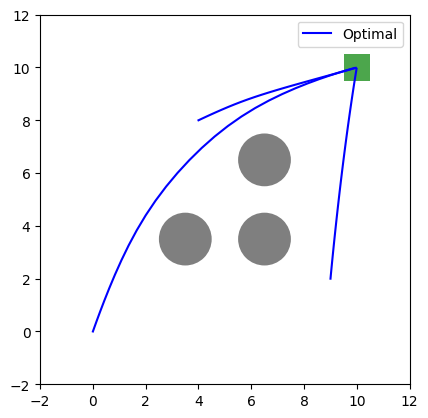

In [8]:
# HTML(animatePointMass(xs_optimal, obs_set, target_high).to_jshtml())
# plot_1_traj(xs_optimal, obs_set, target_high, label='Optimal', linemap = 'b')
plot_1_set(xs_optimal_set, obs_set, target_high, label='Optimal', linemap_traj = 'b', linemap_set = 'b')

In [9]:
# # # Non-Optimal Demo Collection from Optimal
K_nonopt = 5 # Number of Non-Optimal noisy trajectory per optimal and non-optimal trajectories initiated before
scales_opt = 5.0
scales_nopt = 5.0
for k_nopt in range(K_nonopt):
    for x_i, x0 in enumerate(x0s):
        problem.x0 = x0
        Us = us_optimal_set[x_i].copy()+np.random.normal(loc = 0.0, scale=scales_opt, size=np.stack(us_optimal_set[x_i].tolist()).shape)
        US_set[x_i].append(Us)
        XS_set[x_i].append(np.stack(problem.rollout([Us[i] for i in range(T)])))

        Us = US_set[x_i][0].copy()+np.random.normal(loc = 0.0, scale=scales_nopt, size=np.stack(US_set[x_i][0].tolist()).shape)
        US_set[x_i].append(Us)
        XS_set[x_i].append(np.stack(problem.rollout([Us[i] for i in range(T)])))
        


In [10]:
o = []
# for i, X in enumerate(xs_non_optimal_set):
#     o.append(np.exp(-np.linalg.norm(xs_optimal-X)))
# o = np.vstack(o)
# print(o/np.max(o))

In [11]:
# IRL Algorithm
from scipy.optimize import minimize
from scipy.optimize import Bounds

def fcn_w(x, 
          cost_set, 
          xs_optimal, 
          us_optimal, 
          xs_non_optimal_set, 
          us_non_optimal_set, 
          dt, 
          o, 
          Lambda = 0.001, 
          optimality_factor=True):
    
    nr = cost_set.nr
    output = 0
    num = np.nextafter(0,1)
    den = np.nextafter(0,1)
    num += np.exp(-cost_set.traj_cost(xs_optimal, us_optimal, x[:nr], x[nr:], dt))
    den += num
    for i, (Xs, Us) in enumerate(zip(xs_non_optimal_set, us_non_optimal_set)):
        if optimality_factor:
            # o_i = np.exp(-np.linalg.norm(xs_optimal-Xs)) # Optimality factor
            o_i = o[i]
        else:
            o_i = 1
        den += o_i*np.exp(-cost_set.traj_cost(Xs, Us, x[:nr], x[nr:], dt))
    output -= np.log(num/den)
    # output -= num/den
    output += Lambda*np.linalg.norm(x)
    return output

def fcn_w_ND(x, 
          cost_set, 
          xs_optimal_set, 
          us_optimal_set, 
          XS_set, 
          US_set, 
          dt, 
          o, 
          Lambda = 0.001, 
          optimality_factor=True):
    
    nr = cost_set.nr
    output = 0
    for i_opt, (x_opt, us_opt) in enumerate(zip(xs_optimal_set, us_optimal_set)):
        num = np.nextafter(0,1)
        den = np.nextafter(0,1)
        num += np.exp(-cost_set.traj_cost(x_opt, us_opt, x[:nr], x[nr:], dt))
        den += num
        for i, (Xs, Us) in enumerate(zip(XS_set[i_opt], US_set[i_opt])):
            den += np.max([np.nextafter(0,1), np.exp(-cost_set.traj_cost(Xs, Us, x[:nr], x[nr:], dt))])
        output -= np.log(num/den)
    # output -= num/den
    output += Lambda*np.linalg.norm(x)
    return output

In [12]:
dt = timeStep
Lambda = 0.01
lb = 0.0; ub = np.inf
bnds = Bounds(lb, ub)
# opt = o/np.linalg.norm(o)
# opt = o/np.max(o)
opt = o
OF = False # Use Optimality Factor
options = {'maxiter': 100, 'iprint': 1,'ftol': 1e-15 ,'gtol' : 1e-15}
tol = 1e-15
w_rand = np.random.uniform(0.0, 1.0, len(w_des))


# w0 = random.choice(w_bads)
# w0 = w_des
# w0 = w_rand
w0 = np.zeros_like(w_des)

# # For 1 Demo
# res = minimize(fcn_w, 
#                w0, 
#                args=(cost_set, xs_optimal, us_optimal, xs_non_optimal_set, us_non_optimal_set, dt, opt, Lambda, OF), 
#                bounds=bnds, 
#                method='L-BFGS-B', 
#                tol = tol,
#                options=options)

# For N Demos
res_nd = minimize(fcn_w_ND, 
               w0, 
               args=(cost_set, xs_optimal_set, us_optimal_set, XS_set, US_set, dt, opt, Lambda, OF), 
               bounds=bnds, 
               method='L-BFGS-B', 
               tol = tol,
               options=options)

print(res_nd)
w_irl = res_nd.x
    

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0        12 variables are exactly at the bounds

At iterate    0    f=  7.45472D+00    |proj g|=  3.35570D+01

At iterate    1    f=  7.28460D+00    |proj g|=  6.89464D+00

At iterate    2    f=  7.21797D+00    |proj g|=  6.80844D+00

At iterate    3    f=  6.60494D+00    |proj g|=  2.72513D+01

At iterate    4    f=  5.76933D+00    |proj g|=  2.00533D+01

At iterate    5    f=  4.68582D+00    |proj g|=  4.22430D+00

At iterate    6    f=  4.03503D+00    |proj g|=  1.25381D+00

At iterate    7    f=  3.53875D+00    |proj g|=  8.10040D-01

At iterate    8    f=  3.18643D+00    |proj g|=  5.20205D-01

At iterate    9    f=  2.91440D+00    |proj g|=  3.32921D-01

At iterate   10    f=  2.66824D+00    |proj g|=  2.08156D-01

At iterate   11    f=  2.43864D+00    |proj g|=  2.01602D-01

At iterate   12    f=  2.26054D+00    |proj g|=  1.92600D-01

At iterate   13    f=  2.1

In [13]:
# w_irl /= np.max(w_irl)
for i, cost in enumerate(cost_set.costs):
    print(cost.name, ':')
    print('Running || ', 'Desired: ', w_des[:nr][i], 'IRL: ', w_irl[:nr][i])
    print('Terminal || ', 'Desired: ', w_des[nr:][i], 'IRL: ', w_irl[nr:][i])
    print('')

trans_high :
Running ||  Desired:  0.005 IRL:  0.0
Terminal ||  Desired:  1.0 IRL:  11.91243330551974

XReg :
Running ||  Desired:  0.0005 IRL:  0.0
Terminal ||  Desired:  0.0005 IRL:  0.0

UReg :
Running ||  Desired:  0.0005 IRL:  0.0
Terminal ||  Desired:  0.0005 IRL:  0.0

Obs1 :
Running ||  Desired:  0.5 IRL:  2.4362951788803304
Terminal ||  Desired:  0.005 IRL:  0.0

Obs2 :
Running ||  Desired:  0.5 IRL:  11.180828833063828
Terminal ||  Desired:  0.005 IRL:  0.0

Obs3 :
Running ||  Desired:  0.5 IRL:  0.05165902427615925
Terminal ||  Desired:  0.005 IRL:  0.0



In [14]:
print('Desired Trajectory Cost: ', cost_set.traj_cost(xs_optimal, us_optimal, w_des[:nr], w_des[nr:], timeStep))
print('with IRL Weight:         ', cost_set.traj_cost(xs_optimal, us_optimal, w_irl[:nr], w_irl[nr:], timeStep))
print('with Random Weight:      ', cost_set.traj_cost(xs_optimal, us_optimal, w_rand[:nr], w_rand[nr:], timeStep))

Desired Trajectory Cost:  1.0911065748934314
with IRL Weight:          0.5135220362122473
with Random Weight:       682.8905692695648


In [15]:
# Test IRL Output
print('Desired Fcn:    ', fcn_w(w_des, cost_set, xs_optimal, us_optimal, XS_set[0], US_set[0], dt, o, Lambda, OF))
print('IRL Fcn:        ', fcn_w(w_irl, cost_set, xs_optimal, us_optimal, XS_set[0], US_set[0], dt, o, Lambda, OF))
print('Random Fcn:     ', fcn_w(w_rand, cost_set, xs_optimal, us_optimal, XS_set[0], US_set[0], dt, o, Lambda, OF))

# print('Bad Fcn:        ', fcn_w(x0, cost_set, xs_optimal, us_optimal, xs_non_optimal_set, us_non_optimal_set, dt, Lambda))

Desired Fcn:     1.2649915574183939
IRL Fcn:         0.169388403392283
Random Fcn:      122.7654985645881


In [16]:
# Test IRL ND Output
print('Desired Fcn:    ', fcn_w_ND(w_des, cost_set, xs_optimal_set, us_optimal_set, XS_set, US_set, dt, o, Lambda, OF))
print('IRL Fcn:        ', fcn_w_ND(w_irl, cost_set, xs_optimal_set, us_optimal_set, XS_set, US_set, dt, o, Lambda, OF))
print('Random Fcn:     ', fcn_w_ND(w_rand, cost_set, xs_optimal_set, us_optimal_set, XS_set, US_set, dt, o, Lambda, OF))

Desired Fcn:     4.176898930509291
IRL Fcn:         1.4643838921452321
Random Fcn:      153.6558487800639


In [66]:
# Run again with IRL weights
w_run = w_irl[:nr]
w_term = w_irl[nr:]
PM_DAM_running = DifferentialActionModelPointMass(cost_set, w_run)
PM_DAM_terminal = DifferentialActionModelPointMass(cost_set, w_term)
pmDataRunning = PM_DAM_running.createData()
pmDataTerminal = PM_DAM_terminal.createData()
PM_ND_R = crocoddyl.DifferentialActionModelNumDiff(PM_DAM_running, False)
PM_ND_T = crocoddyl.DifferentialActionModelNumDiff(PM_DAM_terminal, False)
timeStep = 5e-2
PM_IAM = crocoddyl.IntegratedActionModelEuler(PM_ND_R, timeStep)
PM_IAM_T = crocoddyl.IntegratedActionModelEuler(PM_ND_T, 0.0)

# x_test = start_point
x_test = np.array([0.0, 0.0, 0.0, 0.0])
x_test[:nq] = np.random.choice(range(-1, 5), nq)
u_test = np.array([0.0, 0.0])
problem = crocoddyl.ShootingProblem(x_test, [PM_IAM] * T, PM_IAM_T)

# Creating the SQP solver
sqp_test = mim_solvers.SolverSQP(problem)
sqp_test.setCallbacks([crocoddyl.CallbackVerbose()])
sqp_test.with_callbacks=True
sqp_test.termination_tolerance = 1e-5
xs_init = [x_test for i in range(T+1)]
us_init = [u_test for i in range(T)]
# xs_init = [xs_optimal[i] for i in range(T+1)]
# us_init = [us_optimal[i] for i in range(T)]

# Solving this problem
done = sqp_test.solve(xs_init, us_init, 500)
xs_output = np.stack(sqp_test.xs.tolist().copy())
us_output = np.stack(sqp_test.us.tolist().copy())


iter     merit         cost         grad      step    ||gaps||        KKT
   1  8.63651e+02  8.63651e+02  4.21220e+01  1.0000  0.00000e+00  1.07212e+02
   2  5.46611e+00  5.46611e+00  5.07179e+00  1.0000  1.84297e-14  2.55595e+00
   3  3.64297e+00  3.64297e+00  1.70607e+01  1.0000  6.39610e-09  1.66934e+00
   4  1.70230e-01  1.70230e-01  4.28586e+00  1.0000  2.54874e-08  8.90916e-01
   5  2.93977e-02  2.93977e-02  1.18768e+01  1.0000  5.92708e-09  3.59314e-02
   6  1.24423e-02  1.24422e-02  5.09354e+00  1.0000  2.02091e-08  1.54026e-02
   7  8.32412e-03  8.32411e-03  6.83789e+00  1.0000  7.36115e-09  6.28992e-03
   8  1.97930e-03  1.97929e-03  5.63691e+00  1.0000  8.19232e-09  3.18236e-03
   9  2.44399e-05  2.44346e-05  2.16860e+00  1.0000  5.21389e-09  2.66986e-04
  10  4.21576e-07  4.19212e-07  1.72058e-01  1.0000  2.36327e-09  3.35686e-05
iter     merit         cost         grad      step    ||gaps||        KKT
 END  1.06017e-09  8.40219e-10  1.04035e-02   ----   2.19948e-10  1.5617

In [67]:
print('IRL Trajectory Cost: ', cost_set.traj_cost(xs_output, us_output, w_irl[:nr], w_irl[nr:], timeStep), 
      ' || with Desired Weight:  ', cost_set.traj_cost(xs_output, us_output, w_des[:nr], w_des[nr:], timeStep), 
      ' || with Random Wight', cost_set.traj_cost(xs_output, us_output, w_rand[:nr], w_rand[nr:], timeStep))

IRL Trajectory Cost:  8.402193718999312e-10  || with Desired Weight:   1.2397121585358069  || with Random Wight 1000.481834761151


In [68]:
print('IRL Trajectory Cost:      ', cost_set.traj_cost(xs_output, us_output, w_irl[:nr], w_irl[nr:], timeStep))
print('Desired Trajectory Cost:  ', cost_set.traj_cost(xs_optimal, us_optimal, w_des[:nr], w_des[nr:], timeStep))

IRL Trajectory Cost:       8.402193718999312e-10
Desired Trajectory Cost:   1.0911065748934314


In [69]:
print('IRL Trajectory with Desired Cost: ', cost_set.traj_cost(xs_output, us_output, w_des[:nr], w_des[nr:], timeStep))
print('Initial Optimal Trajectory Cost:  ', cost_set.traj_cost(xs_optimal, us_optimal, w_des[:nr], w_des[nr:], timeStep))

IRL Trajectory with Desired Cost:  1.2397121585358069
Initial Optimal Trajectory Cost:   1.0911065748934314


In [70]:
# plot_results(xs_optimal, xs_non_optimal_set, xs_output, obs_set, target_high)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


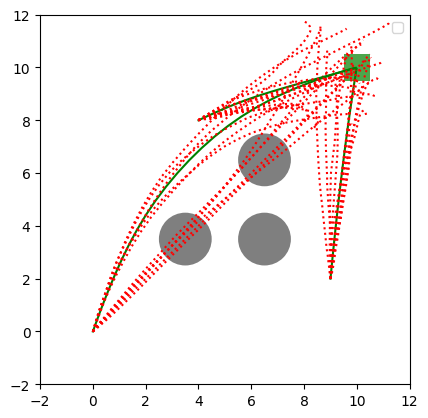

In [71]:
plot_1_multiset(xs_optimal_set, XS_set, obs_set, target_high, label='' , linemap_traj = 'g', linemap_set = 'r:')

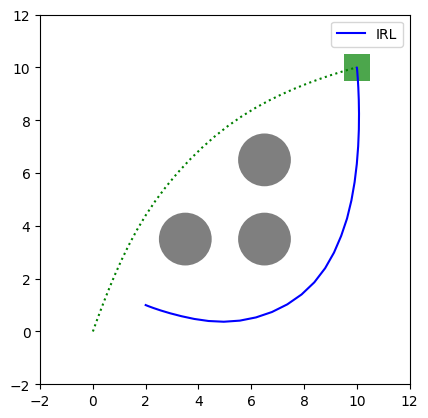

In [72]:
plot_1_set([xs_output, xs_optimal_set[0]], obs_set, target_high, label='IRL', linemap_traj='b', linemap_set='g:')

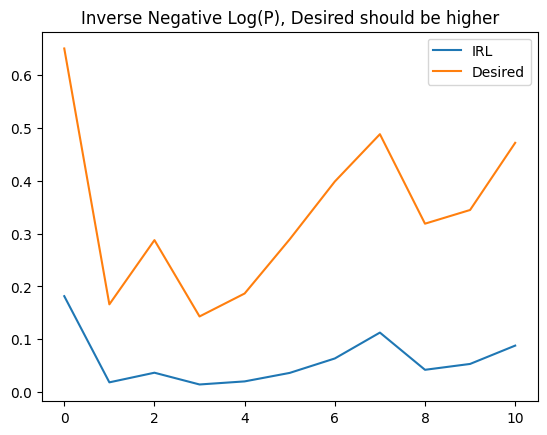

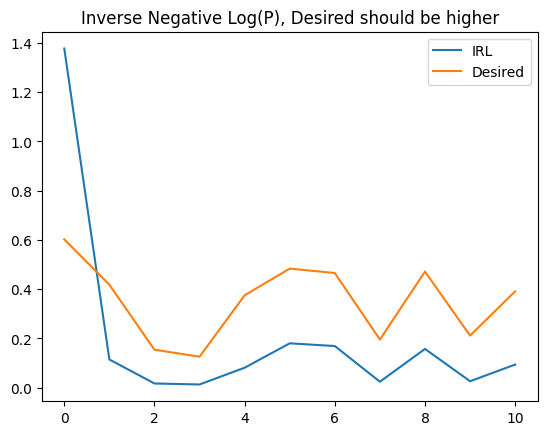

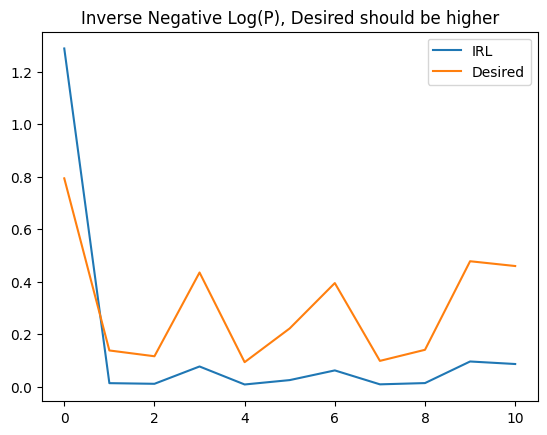

In [73]:
for xs_opt, us_opt, xs_non_opt, us_non_opt in zip(xs_optimal_set, us_optimal_set, XS_set, US_set):
    P_irl = distributions(cost_set, xs_opt, us_opt, xs_non_opt, us_non_opt, w_irl[:nr], w_irl[nr:], dt)
    P_des = distributions(cost_set, xs_opt, us_opt, xs_non_opt, us_non_opt, w_des[:nr], w_des[nr:], dt)
    plt.plot(-1/np.log(P_irl[1:]),label='IRL')
    plt.plot(-1/np.log(P_des[1:]),label='Desired')
    plt.legend()
    plt.title('Inverse Negative Log(P), Desired should be higher')
    plt.show()